#  Milestone Project 2: Skim Lit 🔥 

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The model architecture to achieve their best results can be found in the [paper](https://arxiv.org/pdf/1612.05251.pdf)

## Confirm access to a GPU

In [4]:
!nvidia-smi -L

GPU 0: Quadro P2000 (UUID: GPU-45eb6a28-8b9a-6cc9-5299-32453fd1cd04)


## Get data

Since we'll be replicating the paper above (PubMed 200K RCT), let's download the dataset

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

In [2]:
# Start our experiements using the 20k dataset with numbers replaced by "@" sign
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [3]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Now we've got some text data, it's time to become one with the data. 

Let's write a function to read in all of the lines of a target text files.

In [4]:
# Create a function to read the lines of a document
def get_lines(filename):
    """
    Reads filename (a text filename) and returns the lines of text as a list

    Args: 
        filename: a string containing the target filepath. 

    Returns:
        A list of strings with one string per line from the target filename
    """

    with open(filename,"r") as f:
        return f.readlines()        


In [5]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt") # read the lines with the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [6]:
len(train_lines)

210040

Let's think about how we want our data to look ...

How I think our data would be best represented ...

```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': "Emotional eating is associated with overeating and the development of obesity .\n",
   'total_lines': 11},
   ...]
```   

Let's write a function which turns each of our datasets into the above format so we can continue to prepare our data for modelling

In [7]:
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dictionaries of abstract line data.

    Takes in a filename, reads its contents and sorts through each line, extracing things like the target label,
    the text of the sentence, how many sentences are in the current abstract and what sentence number the target line is
    
    """

    input_lines = get_lines(filename) # get all lines from filename
    abstract_lines = "" # create an empty abstract
    abstract_samples = [] # create an empty list of abstracts

    # Loop through each line
    for line in input_lines:
        if line.startswith("###"): # check to see if this is an ID line
            abstract_id = line
            abstract_lines = "" # reset the abstract string if the line is an ID line
        elif line.isspace(): # check to see if line is a new line
            abstract_line_split = abstract_lines.splitlines() # split abstract into seperate lines

            # Iterate through each line in a single abstract and count them
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # create an empty dictionary for each line
                target_text_split = abstract_line.split("\t") # split target label from text
                line_data["target"] = target_text_split[0] # get target label
                line_data["text"] = target_text_split[1].lower() # get target text and lower it
                line_data["line_number"] = abstract_line_number # what number line does the line appear
                line_data["total_lines"] = len(abstract_line_split)-1 # how many total lines
                abstract_samples.append(line_data) # add line data to abstract samples list

        else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
            abstract_lines += line

    return abstract_samples

In [8]:
# Get the data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135


In [9]:
# Check the first abstract of training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that oour data is in the format of a list of dictionaries, lets turn it into a DataFrame to visualize the data

In [10]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [11]:
# Distribution of labels in training data
train_df.target.value_counts(0)

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

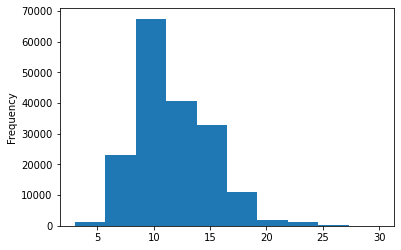

In [12]:
# Length of different lines
train_df.total_lines.plot.hist();

### Get lists of sentences

In [13]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [14]:
# View the first 10 lines of training
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

##  Making numerical labels (ML models require numeric labels)

In [15]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

one_hot_encoder = OneHotEncoder(sparse=False) # we want a non-sparse matrix

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

# Check what one hot encoded labels look like
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### Label encode labels

In [16]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check what the training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [17]:
# Get class names and number of classes from LabelEncoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Starting a series of modelling experiments ...

As usual, we're going to be trying out a bunch of different models and seeing which one works best

## Model 0: Getting a baseline

In [18]:
# Build a Naive-Bayes model using sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf",TfidfVectorizer()), # convert words to numbers
    ("clf",MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)



Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [19]:
# Evaluate baseline model on validation data
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [20]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function

Import from `helper_functions.py`

In [21]:
from Functions.helper_functions import calculate_results

# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)

baseline_results                                     

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [68]:
# Make a quick function to save model results as a (.json) file in case kernel reloads

def save_model_results_json(filepath,var_to_save,file_string):
    """
    This function allows you to save results from a model and store them as a (.json) file

    Args:
        filepath: destination of where you want results saved
        var_to_save: variable you are saving
        file_string: name of file you are saving
    """
    import json

    with open(filepath+"/"+file_string+".json",'w') as f:
        json.dump(var_to_save,f)


In [67]:
# Try out saving our model results
des_path = r"Results\09_Notebook" # (r) ignores the forward slash
save_model_results_json(filepath=des_path,
                        var_to_save=baseline_results,
                        file_string="baseline_results")

In [22]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Preparing our data (the text for deep sequence models)

Before we start building deep models, we have to create vectorization and embedding layers

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [24]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = np.mean(sent_lens)
avg_sent_lens

26.338269273494777

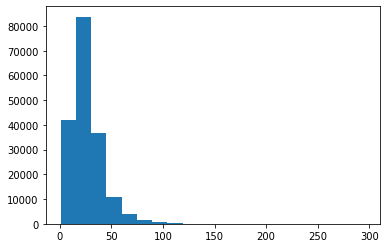

In [25]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [26]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

In [27]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our text from words to numbers

In [28]:
# How many words are in our vocab (taken from paper)
max_tokens = 68_000

In [29]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocab
                                    output_sequence_length=output_seq_len) # desired output of vectorized sequences

In [30]:
# Adapt text vecortizer to training sentences
text_vectorizer.adapt(train_sentences)

In [31]:
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)

print(f"Text:\n {target_sentence}")
print(f"\nLength: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
 initiation of txa treatment within @ hours of injury reduced the hazard of death due to bleeding on the day of the injury by @ % ( hr = @ , @ to @ ) .

Length: 36

Vectorized text: [[1182    4 4614   19  219  227    4  503  191    2  426    4  339  434
     6  506   18    2  108    4    2  503   22  273    6    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [32]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [33]:
# Get the config of text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Create custom text embedding

In [34]:
from tensorflow.keras import layers
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # how many words in vocab
                               output_dim=128, # output size
                               mask_zero=True, # use this to handle different sizes of inputs (zeros in the data  ater tokenization)
                               name="token_embedding")

In [35]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 initiation of txa treatment within @ hours of injury reduced the hazard of death due to bleeding on the day of the injury by @ % ( hr = @ , @ to @ ) .

Sentence after vectorization (before embedding):
 [[1182    4 4614   19  219  227    4  503  191    2  426    4  339  434
     6  506   18    2  108    4    2  503   22  273    6    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[-0.01572935 -0.00097392  0.0211837  ... -0.03844701 -0.0284526
   -0.04553992]
  [ 0.02297575 -0.00383613 -0.01959579 ...  0.02262744  0.01346557
    0.01091318]
  [-0.0318481  -0.00570415  0.0066759  ...  0.04227897 -0.02944832
    0.03901583]
  ...
  [-0.00551528  0.04725328  0.01143631 ...  0.02184326 -0.00442076
   -0.01632669]
  [-0.00551528  0.04725328  0.01143631 ...  0.02184326 -0.00442076
   -0.01632669]
  [-0.00551528  0.04725328  0.011

## Creating datasets (making sure our data loads as fast as possible)

We are going to setup our data to run as fast as possible with the `tf.data` API

In [36]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [37]:
# Take the TensorSliceDataset and Prefetch
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [38]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,),dtype="string")
text_vectors = text_vectorizer(inputs) # vectorize inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense output of feature vector
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_1=tf.keras.Model(inputs,outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [39]:
# Visualize prefetched dataset
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [40]:
# Number of samples
len(train_dataset)*32

180064

In [41]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 10s 14ms/step - loss: 0.9272 - accuracy: 0.6330 - val_loss: 0.6873 - val_accuracy: 0.7357
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6553 - accuracy: 0.7575 - val_loss: 0.6326 - val_accuracy: 0.7693
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6144 - accuracy: 0.7752 - val_loss: 0.5964 - val_accuracy: 0.7836


In [42]:
# Evaluate on the whole dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5969 - accuracy: 0.7869


[0.5968884229660034, 0.7869389653205872]

In [43]:
# Make predictions (our model predicts prediction probabilites for each class)
model_1_pred_probs  = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[4.69356507e-01, 1.29929245e-01, 6.33237287e-02, 3.19828182e-01,
         1.75623838e-02],
        [4.11789924e-01, 3.22029293e-01, 1.31488461e-02, 2.44708136e-01,
         8.32383428e-03],
        [1.65300235e-01, 7.94820953e-03, 1.32806681e-03, 8.25388551e-01,
         3.49385482e-05],
        ...,
        [8.18948502e-06, 6.69916160e-04, 5.39359055e-04, 6.07256243e-06,
         9.98776495e-01],
        [4.18929085e-02, 4.36278462e-01, 1.09418295e-01, 5.60897887e-02,
         3.56320500e-01],
        [1.72306582e-01, 7.10168719e-01, 3.24071087e-02, 4.04342674e-02,
         4.46834154e-02]], dtype=float32),
 (30212, 5))

In [44]:
# Convert pred probs to class
model_1_preds = tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [45]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results                                    

{'accuracy': 78.69389646498081,
 'precision': 0.7844267667059949,
 'recall': 0.7869389646498081,
 'f1': 0.7844317735646117}

In [116]:
# Save model results
des_path = r"Saved Results\09_SkimLit_nlp_milestone_project_2"

save_model_results_json(filepath=des_path,
                        var_to_save=model_1_results,
                        file_string="model_1_results")

## Model 2: Feature extraction with pretrained token embeddings

Now lets use pretrained word embeddings from TensorFlow Hub.

[Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder/4)

In [46]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [48]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence[:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 this increased to @ and @ per cent respectively @weeks after surgery , and @ versus @ per cent at @months , with no significant differences between groups .
Sentence after embedding:
 [[-6.47068396e-02 -1.19255688e-02 -2.89772432e-02 -2.39512622e-02
  -7.79061541e-02  5.16276918e-02 -3.20821367e-02 -4.06290181e-02
  -5.07672578e-02  6.18517734e-02  7.04990104e-02 -3.84209529e-02
  -5.05772270e-02 -6.32492006e-02 -3.39710042e-02  4.30458821e-02
  -8.27741101e-02  3.23488303e-02  2.91533265e-02  6.32273927e-02
   9.78377536e-02  5.11389859e-02 -5.25167733e-02 -1.70704313e-02
  -2.48744078e-02  3.50116007e-02 -3.22745517e-02  3.10257971e-02
  -8.41283333e-03 -5.22091165e-02 -3.33797634e-02  9.81570631e-02
   5.32459989e-02 -5.43786176e-02  8.29426385e-03  1.51492590e-02
   4.69498672e-02 -2.94353180e-02  8.86536203e-04 -6.73214793e-02
   1.80679765e-02  6.47641122e-02 -1.30901597e-02 -3.75929028e-02
   2.08593328e-02  4.76661138e-02  3.27960588e-02 -4.56575602e-02
  -1.4

In [ ]:
## Building and fitting a NLP feature extraction model using pretrained embeddings

In [50]:
# Build a model
inputs = layers.Input(shape=[], dtype="string")
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and embedd
x = layers.Dense(128,activation="relu")(pretrained_embedding)
outputs = layers.Dense(5,activation="softmax")(x) # create output layer
model_2 = tf.keras.Model(inputs,outputs,name="model_2_USE_feature_extractor")

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [52]:
# Fit the model
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 17ms/step - loss: 0.9161 - accuracy: 0.6507 - val_loss: 0.7988 - val_accuracy: 0.6882
Epoch 2/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7699 - accuracy: 0.7013 - val_loss: 0.7552 - val_accuracy: 0.7058
Epoch 3/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7526 - accuracy: 0.7133 - val_loss: 0.7375 - val_accuracy: 0.7164


In [53]:
# Evaluate on the whole dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 13s 14ms/step - loss: 0.7405 - accuracy: 0.7141


[0.7405020594596863, 0.7140540480613708]

In [54]:
# Make predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 10ms/step


array([[4.0893731e-01, 3.6699104e-01, 2.4322842e-03, 2.1457045e-01,
        7.0688967e-03],
       [3.5600561e-01, 4.9153507e-01, 4.9336851e-03, 1.4440186e-01,
        3.1237996e-03],
       [2.3542319e-01, 1.5630831e-01, 2.1132538e-02, 5.4484087e-01,
        4.2295016e-02],
       ...,
       [2.0373813e-03, 8.0747465e-03, 5.8020283e-02, 7.3287316e-04,
        9.3113476e-01],
       [3.4389482e-03, 4.9161490e-02, 2.0220654e-01, 1.1663779e-03,
        7.4402666e-01],
       [1.9459534e-01, 2.7257228e-01, 4.6033832e-01, 6.2345336e-03,
        6.6259585e-02]], dtype=float32)

In [55]:
# Index on labels
model_2_preds = tf.argmax(model_2_pred_probs,axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2], dtype=int64)>

In [59]:
# Calculate results
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results                                

{'accuracy': 71.40540182708858,
 'precision': 0.7141393634649007,
 'recall': 0.7140540182708858,
 'f1': 0.7112713469616521}